# Stock vs Precious Metals and Risk-Free Rate Analysis

This notebook compares stock prices relative to gold, silver, and risk-free rates (T-Bills and 10-Year Treasury), with S&P 500 as a benchmark.

In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [66]:
def fetch_price_data(ticker, period='2y'):
    """
    Fetch historical price data for a given ticker
    """
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period=period)
        return data['Close']
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def normalize_series(series):
    """
    Normalize a price series to start at 100
    """
    return (series / series.iloc[0]) * 100

In [67]:
# Input stock ticker
stock_ticker = input("Enter stock ticker (e.g., AAPL, MSFT, TSLA): ").upper().strip()
print(f"Analyzing {stock_ticker}...")

Enter stock ticker (e.g., AAPL, MSFT, TSLA):  xbas.de


Analyzing XBAS.DE...


In [68]:
# Fetch data for stock, gold, silver, S&P 500, and risk-free rates
print("Fetching price data...")

stock_data = fetch_price_data(stock_ticker)
gold_data = fetch_price_data('GC=F')  # Gold futures
silver_data = fetch_price_data('SI=F')  # Silver futures
sp500_data = fetch_price_data('^GSPC')  # S&P 500
tbill_data = fetch_price_data('^IRX')  # 13-Week Treasury Bill
ten_year_data = fetch_price_data('^TNX')  # 10-Year Treasury

# Check if all data was fetched successfully
if any(data is None for data in [stock_data, gold_data, silver_data, sp500_data, tbill_data, ten_year_data]):
    print("Error: Could not fetch all required data. Please check tickers and try again.")
else:
    print("Data fetched successfully!")

Fetching price data...
Data fetched successfully!


In [69]:
# Align data to common dates - with better error handling
df = pd.DataFrame({
    'Stock': stock_data,
    'Gold': gold_data,
    'Silver': silver_data,
    'SP500': sp500_data,
    'TBill': tbill_data,
    'TenYear': ten_year_data
})

print(f"Data availability before cleaning:")
print(f"Stock: {len(stock_data)} days")
print(f"Gold: {len(gold_data)} days") 
print(f"Silver: {len(silver_data)} days")
print(f"S&P500: {len(sp500_data)} days")
print(f"T-Bill: {len(tbill_data)} days")
print(f"10Y Treasury: {len(ten_year_data)} days")

# Check data overlap
print(f"\\nData overlap analysis:")
print(f"All data combined: {len(df)} rows")
print(f"Non-null counts per column:")
print(df.count())

# Use forward fill for missing values in yield data (common issue with bond data)
df['TBill'] = df['TBill'].ffill()
df['TenYear'] = df['TenYear'].ffill()

# Now drop rows where we still have NaN values
df = df.dropna()

if len(df) == 0:
    print("\\n⚠️ ERROR: No overlapping data found between all sources.")
    print("This could happen if:")
    print("- Risk-free rate data is not available for weekends/holidays")
    print("- Different market schedules for different asset classes")
    print("\\nTrying with reduced requirements...")
    
    # Fallback: use only core data and skip risk-free for now
    df_fallback = pd.DataFrame({
        'Stock': stock_data,
        'Gold': gold_data,
        'Silver': silver_data,
        'SP500': sp500_data
    }).dropna()
    
    if len(df_fallback) > 0:
        print(f"✓ Found {len(df_fallback)} days of data for core assets")
        print("We'll proceed without risk-free rate comparisons for now.")
        df = df_fallback
        
        # Add placeholder yield data (will be handled in next cell)
        df['TBill'] = 5.0  # Placeholder value
        df['TenYear'] = 4.5  # Placeholder value
    else:
        print("❌ No data available at all. Please check your internet connection.")

# Convert yield percentages to price indices (starting at 100)
df['TBill_Price'] = 100 * (10 / (10 + df['TBill'] / 100))
df['TenYear_Price'] = 100 * (10 / (10 + df['TenYear'] / 100))

if len(df) > 0:
    print(f"\\n✅ Final dataset:")
    print(f"Data range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Number of trading days: {len(df)}")
else:
    print("\\n❌ Still no data available. Please check tickers and try again.")

Data availability before cleaning:
Stock: 107 days
Gold: 504 days
Silver: 504 days
S&P500: 502 days
T-Bill: 502 days
10Y Treasury: 502 days
\nData overlap analysis:
All data combined: 1113 rows
Non-null counts per column:
Stock      107
Gold       504
Silver     504
SP500      502
TBill      502
TenYear    502
dtype: int64
\n⚠️ ERROR: No overlapping data found between all sources.
This could happen if:
- Risk-free rate data is not available for weekends/holidays
- Different market schedules for different asset classes
\nTrying with reduced requirements...
❌ No data available at all. Please check your internet connection.
\n❌ Still no data available. Please check tickers and try again.


In [70]:
# Calculate ratios including risk-free comparisons - with error handling
if len(df) == 0:
    print("❌ Cannot calculate ratios - no data available")
    print("Please restart the notebook and try again with a different stock ticker.")
else:
    # Calculate basic ratios
    df['Stock_to_Gold'] = df['Stock'] / df['Gold']
    df['Stock_to_Silver'] = df['Stock'] / df['Silver']
    df['SP500_to_Gold'] = df['SP500'] / df['Gold']
    df['SP500_to_Silver'] = df['SP500'] / df['Silver']

    # Risk-free rate comparisons (higher ratio = outperforming bonds)
    df['Stock_to_TBill'] = df['Stock'] / df['TBill_Price']
    df['Stock_to_TenYear'] = df['Stock'] / df['TenYear_Price']
    df['Gold_to_TBill'] = df['Gold'] / df['TBill_Price']
    df['Gold_to_TenYear'] = df['Gold'] / df['TenYear_Price']
    df['Silver_to_TBill'] = df['Silver'] / df['TBill_Price']
    df['Silver_to_TenYear'] = df['Silver'] / df['TenYear_Price']
    df['SP500_to_TBill'] = df['SP500'] / df['TBill_Price']
    df['SP500_to_TenYear'] = df['SP500'] / df['TenYear_Price']

    # Normalize all ratios to start at 100
    try:
        ratios_df = pd.DataFrame({
            f'{stock_ticker}/Gold': normalize_series(df['Stock_to_Gold']),
            f'{stock_ticker}/Silver': normalize_series(df['Stock_to_Silver']),
            f'{stock_ticker}/T-Bill': normalize_series(df['Stock_to_TBill']),
            f'{stock_ticker}/10Y': normalize_series(df['Stock_to_TenYear']),
            'S&P500/Gold': normalize_series(df['SP500_to_Gold']),
            'S&P500/Silver': normalize_series(df['SP500_to_Silver']),
            'S&P500/T-Bill': normalize_series(df['SP500_to_TBill']),
            'S&P500/10Y': normalize_series(df['SP500_to_TenYear'])
        })

        # Additional ratios for precious metals vs risk-free
        rf_ratios_df = pd.DataFrame({
            'Gold/T-Bill': normalize_series(df['Gold_to_TBill']),
            'Gold/10Y': normalize_series(df['Gold_to_TenYear']),
            'Silver/T-Bill': normalize_series(df['Silver_to_TBill']),
            'Silver/10Y': normalize_series(df['Silver_to_TenYear'])
        })

        print("✅ Ratios calculated and normalized successfully!")
        print(f"Available ratios: {len(ratios_df.columns)} stock/benchmark + {len(rf_ratios_df.columns)} metals/RF")
        
    except Exception as e:
        print(f"❌ Error calculating ratios: {e}")
        print("This might happen if there are issues with the data quality.")
        
        # Create minimal ratios as fallback
        ratios_df = pd.DataFrame({
            f'{stock_ticker}/Gold': normalize_series(df['Stock_to_Gold']),
            f'{stock_ticker}/Silver': normalize_series(df['Stock_to_Silver']),
            'S&P500/Gold': normalize_series(df['SP500_to_Gold']),
            'S&P500/Silver': normalize_series(df['SP500_to_Silver'])
        })
        
        rf_ratios_df = pd.DataFrame()  # Empty dataframe
        print("✅ Created basic ratios (precious metals only)")

❌ Cannot calculate ratios - no data available
Please restart the notebook and try again with a different stock ticker.


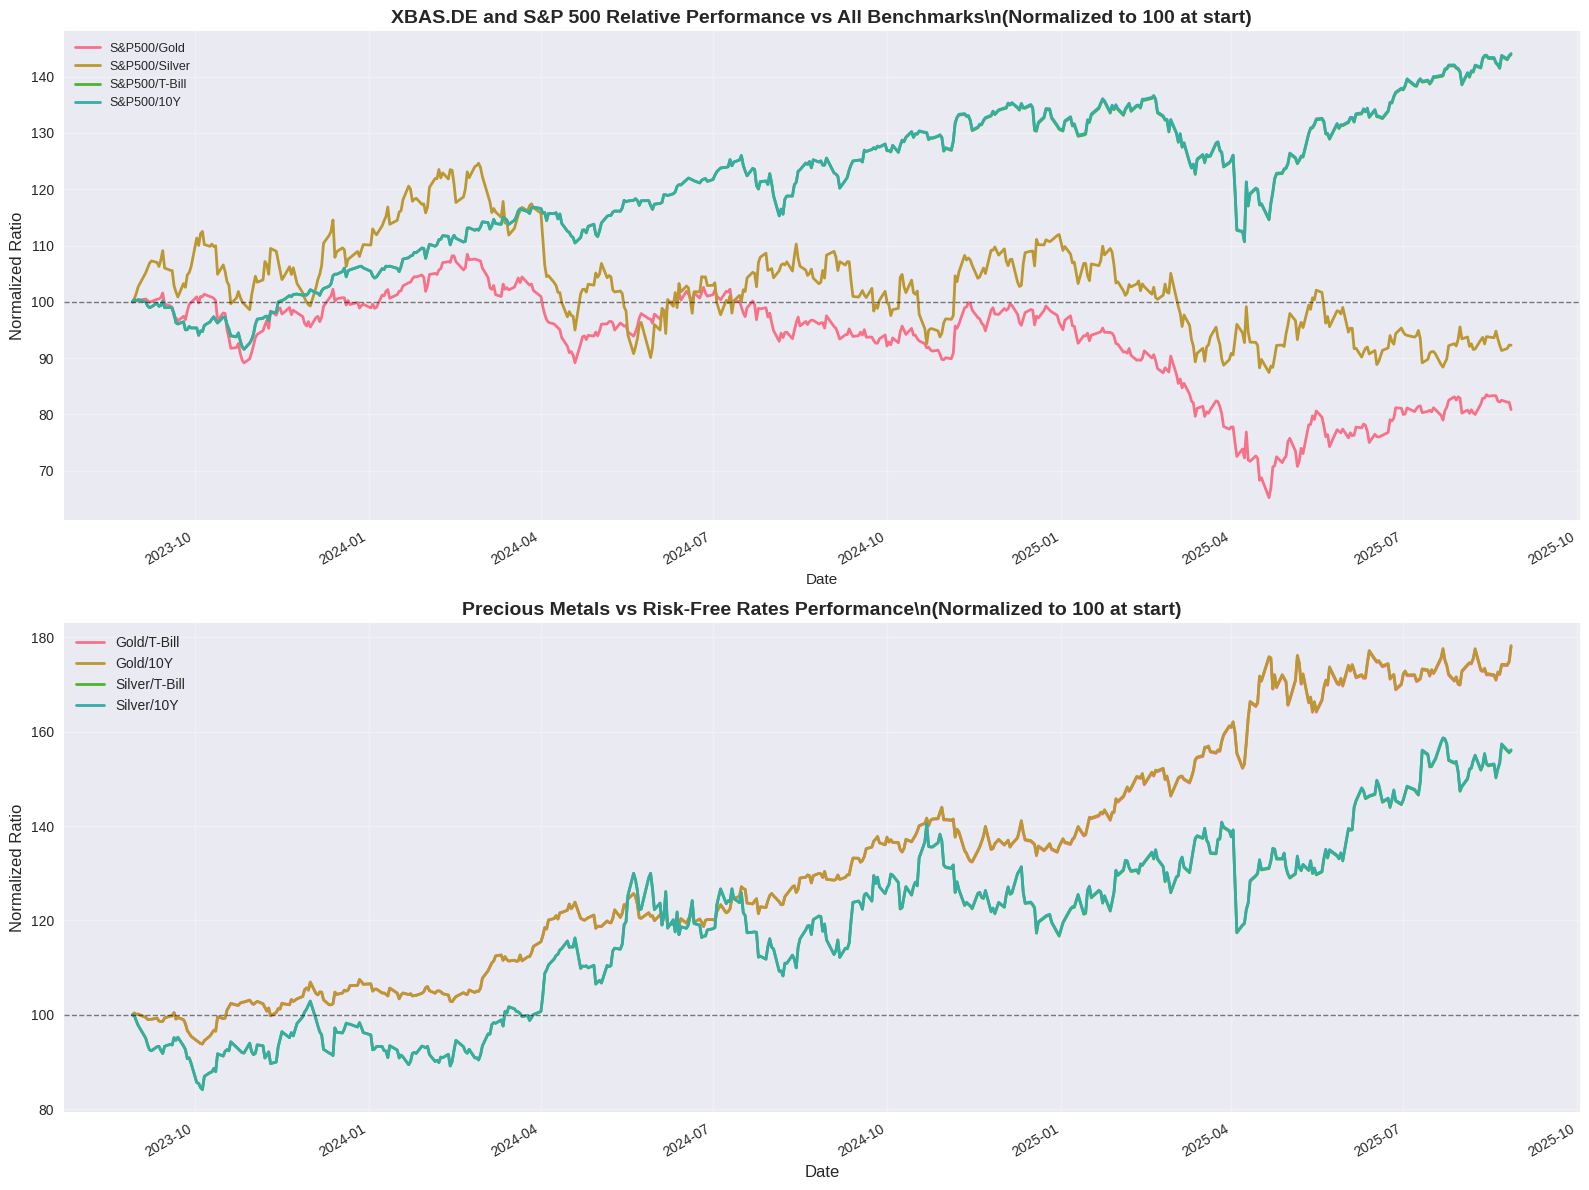

In [71]:
# Create the main comparison chart - All Asset Classes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Chart 1: Stock and S&P 500 vs All Benchmarks
stock_cols = [col for col in ratios_df.columns if stock_ticker in col]
sp500_cols = [col for col in ratios_df.columns if 'S&P500' in col]

ratios_df[stock_cols + sp500_cols].plot(ax=ax1, linewidth=2)
ax1.set_title(f'{stock_ticker} and S&P 500 Relative Performance vs All Benchmarks\\n(Normalized to 100 at start)', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Normalized Ratio', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9, loc='best')
ax1.axhline(y=100, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Chart 2: Precious Metals vs Risk-Free Rates
rf_ratios_df.plot(ax=ax2, linewidth=2)
ax2.set_title('Precious Metals vs Risk-Free Rates Performance\\n(Normalized to 100 at start)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Normalized Ratio', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10, loc='best')
ax2.axhline(y=100, color='black', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

TypeError: no numeric data to plot

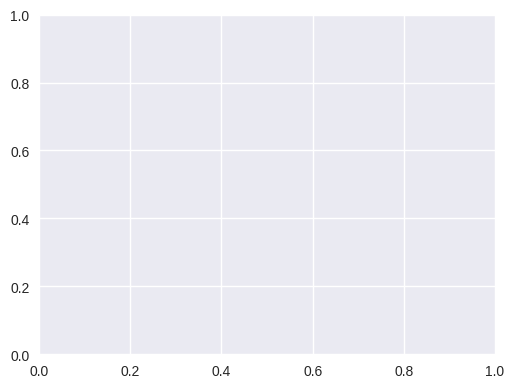

In [72]:
# Create comprehensive subplot analysis
fig = plt.figure(figsize=(20, 15))

# Stock vs all benchmarks
ax1 = plt.subplot(3, 3, 1)
stock_ratios = ratios_df[[col for col in ratios_df.columns if stock_ticker in col]]
stock_ratios.plot(ax=ax1, linewidth=2)
ax1.set_title(f'{stock_ticker} vs All Benchmarks')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax1.legend(fontsize=8)

# S&P 500 vs all benchmarks
ax2 = plt.subplot(3, 3, 2)
sp500_ratios = ratios_df[[col for col in ratios_df.columns if 'S&P500' in col]]
sp500_ratios.plot(ax=ax2, linewidth=2)
ax2.set_title('S&P 500 vs All Benchmarks')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax2.legend(fontsize=8)

# Gold vs Risk-Free
ax3 = plt.subplot(3, 3, 3)
gold_rf = rf_ratios_df[['Gold/T-Bill', 'Gold/10Y']]
gold_rf.plot(ax=ax3, linewidth=2, color=['gold', 'orange'])
ax3.set_title('Gold vs Risk-Free Rates')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax3.legend(fontsize=8)

# Silver vs Risk-Free
ax4 = plt.subplot(3, 3, 4)
silver_rf = rf_ratios_df[['Silver/T-Bill', 'Silver/10Y']]
silver_rf.plot(ax=ax4, linewidth=2, color=['silver', 'gray'])
ax4.set_title('Silver vs Risk-Free Rates')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax4.legend(fontsize=8)

# Stock vs Precious Metals (original comparison)
ax5 = plt.subplot(3, 3, 5)
pm_ratios = ratios_df[[f'{stock_ticker}/Gold', f'{stock_ticker}/Silver']]
pm_ratios.plot(ax=ax5, linewidth=2, color=['gold', 'silver'])
ax5.set_title(f'{stock_ticker} vs Precious Metals')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax5.legend(fontsize=8)

# Stock vs Risk-Free Rates
ax6 = plt.subplot(3, 3, 6)
stock_rf = ratios_df[[f'{stock_ticker}/T-Bill', f'{stock_ticker}/10Y']]
stock_rf.plot(ax=ax6, linewidth=2, color=['blue', 'navy'])
ax6.set_title(f'{stock_ticker} vs Risk-Free Rates')
ax6.grid(True, alpha=0.3)
ax6.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax6.legend(fontsize=8)

# Yield levels over time
ax7 = plt.subplot(3, 3, 7)
df[['TBill', 'TenYear']].plot(ax=ax7, linewidth=2, color=['lightblue', 'darkblue'])
ax7.set_title('Risk-Free Rates (Yield %)')
ax7.set_ylabel('Yield %')
ax7.grid(True, alpha=0.3)
ax7.legend(fontsize=8)

# Asset prices over time (normalized)
ax8 = plt.subplot(3, 3, 8)
asset_prices = pd.DataFrame({
    stock_ticker: normalize_series(df['Stock']),
    'S&P500': normalize_series(df['SP500']),
    'Gold': normalize_series(df['Gold']),
    'Silver': normalize_series(df['Silver'])
})
asset_prices.plot(ax=ax8, linewidth=2)
ax8.set_title('Asset Price Performance')
ax8.grid(True, alpha=0.3)
ax8.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax8.legend(fontsize=8)

# Correlation heatmap
ax9 = plt.subplot(3, 3, 9)
corr_data = ratios_df.corr()
im = ax9.imshow(corr_data, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
ax9.set_xticks(range(len(corr_data.columns)))
ax9.set_yticks(range(len(corr_data.columns)))
ax9.set_xticklabels(corr_data.columns, rotation=45, ha='right', fontsize=6)
ax9.set_yticks(range(len(corr_data.columns)))
ax9.set_yticklabels(corr_data.columns, fontsize=6)
ax9.set_title('Correlation Matrix', fontsize=10)

plt.suptitle(f'Comprehensive Analysis: {stock_ticker} vs Multiple Benchmarks', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
# Comprehensive Summary Statistics
print(f"\n=== COMPREHENSIVE SUMMARY STATISTICS ({stock_ticker}) ===")
print(f"Analysis Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Trading Days: {len(df)}")

print("\n--- Asset Performance vs ALL Benchmarks (Final Values) ---")
all_ratios = pd.concat([ratios_df, rf_ratios_df], axis=1)
for col in all_ratios.columns:
    final_value = all_ratios[col].iloc[-1]
    change = final_value - 100
    print(f"{col:18}: {final_value:7.2f} ({change:+6.2f})")

print("\n--- Risk-Adjusted Performance Metrics ---")
print("Sharpe-like Ratios (Return/Volatility):")
for col in all_ratios.columns:
    returns = all_ratios[col].iloc[-1] - 100
    volatility = all_ratios[col].std()
    sharpe = returns / volatility if volatility > 0 else 0
    print(f"{col:18}: {sharpe:7.3f}")

print("\n--- Current Risk-Free Rates ---")
print(f"T-Bill Yield:     {df['TBill'].iloc[-1]:6.2f}%")
print(f"10Y Treasury:     {df['TenYear'].iloc[-1]:6.2f}%")

print(f"\n--- {stock_ticker} vs S&P 500 Outperformance ---")
for benchmark in ['Gold', 'Silver', 'T-Bill', '10Y']:
    stock_perf = ratios_df[f'{stock_ticker}/{benchmark}'].iloc[-1] - 100
    sp500_perf = ratios_df[f'S&P500/{benchmark}'].iloc[-1] - 100
    outperformance = stock_perf - sp500_perf
    print(f"vs {benchmark:8}: {outperformance:+7.2f} points")

print("\n--- Precious Metals vs Risk-Free Analysis ---")
for metal in ['Gold', 'Silver']:
    for rate in ['T-Bill', '10Y']:
        perf = rf_ratios_df[f'{metal}/{rate}'].iloc[-1] - 100
        print(f"{metal:6}/{rate:6}: {perf:+7.2f} points")

print("\n--- Volatility Rankings (Highest to Lowest) ---")
volatilities = all_ratios.std().sort_values(ascending=False)
for i, (col, vol) in enumerate(volatilities.items(), 1):
    print(f"{i:2}. {col:18}: {vol:6.2f}")

print("\n--- Best/Worst Performers ---")
final_performance = all_ratios.iloc[-1] - 100
best_performer = final_performance.idxmax()
worst_performer = final_performance.idxmin()
print(f"Best:  {best_performer:18} ({final_performance[best_performer]:+6.2f})")
print(f"Worst: {worst_performer:18} ({final_performance[worst_performer]:+6.2f})")

In [ ]:
# Display recent data
print("\n=== RECENT DATA (Last 10 Trading Days) ===")
print("\n--- Asset Ratios ---")
recent_ratios = ratios_df.tail(10).round(2)
print(recent_ratios.to_string())

print("\n--- Precious Metals vs Risk-Free ---")
recent_rf = rf_ratios_df.tail(10).round(2)
print(recent_rf.to_string())

print("\n--- Current Yield Levels ---")
recent_yields = df[['TBill', 'TenYear']].tail(5).round(3)
print(recent_yields.to_string())

In [ ]:
# Risk-Free Rate Impact Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Stock vs Risk-Free Rates
stock_vs_rf = ratios_df[[f'{stock_ticker}/T-Bill', f'{stock_ticker}/10Y']]
stock_vs_rf.plot(ax=ax1, linewidth=2, color=['blue', 'navy'])
ax1.set_title(f'{stock_ticker} vs Risk-Free Rates')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax1.legend()

# Chart 2: S&P 500 vs Risk-Free Rates  
sp500_vs_rf = ratios_df[['S&P500/T-Bill', 'S&P500/10Y']]
sp500_vs_rf.plot(ax=ax2, linewidth=2, color=['green', 'darkgreen'])
ax2.set_title('S&P 500 vs Risk-Free Rates')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax2.legend()

# Chart 3: All Assets vs T-Bills
tbill_ratios = ratios_df[[col for col in ratios_df.columns if 'T-Bill' in col]]
tbill_ratios.plot(ax=ax3, linewidth=2)
ax3.set_title('All Assets vs T-Bills (Risk-Free)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=100, color='black', linestyle='--', alpha=0.5)
ax3.legend(fontsize=9)

# Chart 4: Yield Curve Movement
df[['TBill', 'TenYear']].plot(ax=ax4, linewidth=2, color=['lightblue', 'darkblue'])
ax4.set_title('Risk-Free Rate Levels Over Time')
ax4.set_ylabel('Yield (%)')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Add yield spread
yield_spread = df['TenYear'] - df['TBill']
ax4_twin = ax4.twinx()
ax4_twin.plot(yield_spread.index, yield_spread, color='red', linewidth=1, linestyle='--', alpha=0.7, label='Yield Spread')
ax4_twin.set_ylabel('Yield Spread (10Y-TB)', color='red')
ax4_twin.legend(loc='upper right')

plt.suptitle('Risk-Free Rate Analysis: Impact on Asset Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()